# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import re
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine
from sklearn.pipeline import Pipeline, FeatureUnion
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fadwa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Fadwa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fadwa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('Disasters', con=engine)
df.info()

categories = df.columns[4:]

X = df[['message']].values[:, 0]
y = df[categories].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26215 entries, 0 to 26214
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               26215 non-null  int64 
 1   message                          26215 non-null  object
 2   original                         10170 non-null  object
 3   genre                            26215 non-null  object
 4   category_related                 26215 non-null  int64 
 5   category_request                 26215 non-null  int64 
 6   category_offer                   26215 non-null  int64 
 7   category_aid_related             26215 non-null  int64 
 8   category_medical_help            26215 non-null  int64 
 9   category_medical_products        26215 non-null  int64 
 10  category_search_and_rescue       26215 non-null  int64 
 11  category_security                26215 non-null  int64 
 12  category_military               

In [3]:
print (df)

          id                                            message  \
0          2  Weather update - a cold front from Cuba that c...   
1          7            Is the Hurricane over or is it not over   
2          8                    Looking for someone but no name   
3          9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4         12  says: west side of Haiti, rest of the country ...   
...      ...                                                ...   
26210  30261  The training demonstrated how to enhance micro...   
26211  30262  A suitable candidate has been selected and OCH...   
26212  30263  Proshika, operating in Cox's Bazar municipalit...   
26213  30264  Some 2,000 women protesting against the conduc...   
26214  30265  A radical shift in thinking came about as a re...   

                                                original   genre  \
0      Un front froid se retrouve sur Cuba ce matin. ...  direct   
1                     Cyclone nan fini osinon li pa fini  d

### 2. Write a tokenization function to process your text data

In [4]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text, lemmatizer=WordNetLemmatizer()):
    # Detecte URLs
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'urlplaceholder')
    
    # Normalize and tokenize
    tokens = nltk.word_tokenize(re.sub(r"[^a-zA-Z0-9]", " ", text.lower()))
    
    # Remove stopwords
    tokens = [t for t in tokens if t not in stopwords.words('english')]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return tokens

In [5]:
# Check vocabulary
vect = CountVectorizer(tokenizer=tokenize)
X_vectorized = vect.fit_transform(X)

In [6]:
# Convert vocabulary into pandas.dataframe
keys, values = [], []
for k, v in vect.vocabulary_.items():
    keys.append(k)
    values.append(v)

vocabulary = pd.DataFrame.from_dict({'words': keys, 'counts': values})

In [7]:
vocabulary_counts = list(vocabulary['counts'])

In [8]:
pickle.dump(vocabulary_counts, open('vocabulary_stats.pkl', 'wb'))

In [9]:
category_counts = list(y.sum(axis=0))

In [10]:
pickle.dump(category_counts, open('category_stats.pkl', 'wb'))

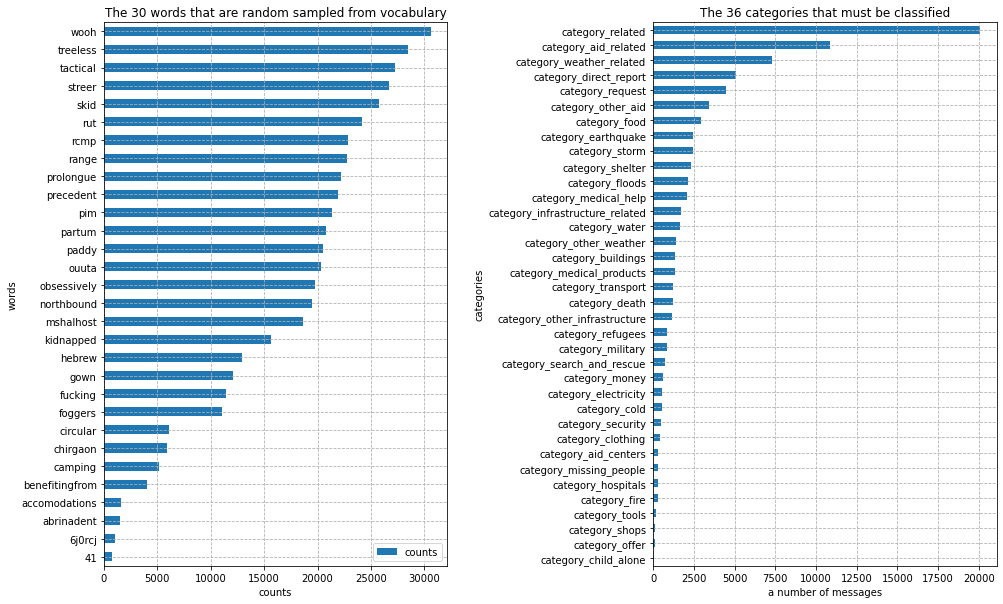

In [11]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(wspace=0.6)

ax1 = plt.subplot(1, 2, 1)
vocabulary.sample(30, random_state=72).sort_values('counts').plot.barh(x='words', y='counts', ax=ax1, colormap='tab10')
plt.title('The 30 words that are random sampled from vocabulary')
plt.xlabel('counts')
plt.grid(linestyle='dashed')

ax2 = plt.subplot(1, 2, 2)
df[categories].sum().sort_values().plot.barh(ax=ax2)
plt.title('The 36 categories that must be classified')
plt.ylabel('categories')
plt.xlabel('a number of messages')
plt.grid(linestyle='dashed')

plt.show()

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [12]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(class_weight='balanced')))
]) 

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [14]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x00000228F161A040>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced')))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [15]:
def multioutput_classification_report(y_true, y_pred):
    for i in range(0, len(categories)):
        print(categories[i])
        print("\tAccuracy: {:.4f}\t\t% Precision: {:.4f}\t\t% Recall: {:.4f}\t\t% F1_score: {:.4f}".format(
            accuracy_score(y_true[:, i], y_pred[:, i]),
            precision_score(y_true[:, i], y_pred[:, i], average='weighted'),
            recall_score(y_true[:, i], y_pred[:, i], average='weighted'),
            f1_score(y_true[:, i], y_pred[:, i], average='weighted')
        ))
        #print(classification_report(y_true[:, i], y_pred[:, i]))
        #print("--------------------------------------------------")

In [16]:
y_pred = pipeline.predict(X_train)

In [17]:
multioutput_classification_report(y_train, y_pred)

category_related
	Accuracy: 0.9981		% Precision: 0.9981		% Recall: 0.9981		% F1_score: 0.9981
category_request
	Accuracy: 0.9989		% Precision: 0.9989		% Recall: 0.9989		% F1_score: 0.9989
category_offer
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
category_aid_related
	Accuracy: 0.9988		% Precision: 0.9988		% Recall: 0.9988		% F1_score: 0.9988
category_medical_help
	Accuracy: 0.9995		% Precision: 0.9995		% Recall: 0.9995		% F1_score: 0.9995
category_medical_products
	Accuracy: 0.9997		% Precision: 0.9997		% Recall: 0.9997		% F1_score: 0.9997
category_search_and_rescue
	Accuracy: 0.9999		% Precision: 0.9999		% Recall: 0.9999		% F1_score: 0.9999
category_security
	Accuracy: 0.9997		% Precision: 0.9997		% Recall: 0.9997		% F1_score: 0.9997
category_military
	Accuracy: 0.9998		% Precision: 0.9998		% Recall: 0.9998		% F1_score: 0.9998
category_child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
category_water
	Accuracy: 0.

In [18]:
y_pred = pipeline.predict(X_test)

In [19]:
multioutput_classification_report(y_test, y_pred)

category_related
	Accuracy: 0.8261		% Precision: 0.8141		% Recall: 0.8261		% F1_score: 0.8123
category_request
	Accuracy: 0.8998		% Precision: 0.8938		% Recall: 0.8998		% F1_score: 0.8914
category_offer
	Accuracy: 0.9950		% Precision: 0.9900		% Recall: 0.9950		% F1_score: 0.9925
category_aid_related
	Accuracy: 0.7823		% Precision: 0.7821		% Recall: 0.7823		% F1_score: 0.7822
category_medical_help
	Accuracy: 0.9255		% Precision: 0.9072		% Recall: 0.9255		% F1_score: 0.8971
category_medical_products
	Accuracy: 0.9553		% Precision: 0.9534		% Recall: 0.9553		% F1_score: 0.9377
category_search_and_rescue
	Accuracy: 0.9731		% Precision: 0.9583		% Recall: 0.9731		% F1_score: 0.9606
category_security
	Accuracy: 0.9835		% Precision: 0.9721		% Recall: 0.9835		% F1_score: 0.9759
category_military
	Accuracy: 0.9660		% Precision: 0.9536		% Recall: 0.9660		% F1_score: 0.9521
category_child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
category_water
	Accuracy: 0.

C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

	Accuracy: 0.8781		% Precision: 0.8753		% Recall: 0.8781		% F1_score: 0.8745
category_floods
	Accuracy: 0.9452		% Precision: 0.9421		% Recall: 0.9452		% F1_score: 0.9337
category_storm
	Accuracy: 0.9387		% Precision: 0.9323		% Recall: 0.9387		% F1_score: 0.9319
category_fire
	Accuracy: 0.9887		% Precision: 0.9775		% Recall: 0.9887		% F1_score: 0.9831
category_earthquake
	Accuracy: 0.9634		% Precision: 0.9617		% Recall: 0.9634		% F1_score: 0.9611
category_cold
	Accuracy: 0.9792		% Precision: 0.9670		% Recall: 0.9792		% F1_score: 0.9703
category_other_weather
	Accuracy: 0.9478		% Precision: 0.9248		% Recall: 0.9478		% F1_score: 0.9233
category_direct_report
	Accuracy: 0.8630		% Precision: 0.8522		% Recall: 0.8630		% F1_score: 0.8476


### 6. Improve your model
Use grid search to find better parameters. 

In [20]:
parameters = {
    'clf__estimator__n_estimators': [20, 50]
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=3, scoring='f1_weighted', verbose=3)

In [21]:

cv.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 1/3] END ................clf__estimator__n_estimators=20; total time= 2.0min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 2/3] END ................clf__estimator__n_estimators=20; total time= 2.1min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 3/3] END ................clf__estimator__n_estimators=20; total time= 2.0min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 1/3] END ................clf__estimator__n_estimators=50; total time= 3.1min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 2/3] END ................clf__estimator__n_estimators=50; total time= 2.9min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 3/3] END ................clf__estimator__n_estimators=50; total time= 3.1min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x00000228F161A040>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced')))]),
             param_grid={'clf__estimator__n_estimators': [20, 50]},
             scoring='f1_weighted', verbose=3)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [22]:
y_pred = cv.predict(X_train)

In [23]:
multioutput_classification_report(y_train, y_pred)

category_related
	Accuracy: 0.9978		% Precision: 0.9978		% Recall: 0.9978		% F1_score: 0.9978
category_request
	Accuracy: 0.9985		% Precision: 0.9985		% Recall: 0.9985		% F1_score: 0.9985
category_offer
	Accuracy: 0.9997		% Precision: 0.9997		% Recall: 0.9997		% F1_score: 0.9997
category_aid_related
	Accuracy: 0.9985		% Precision: 0.9985		% Recall: 0.9985		% F1_score: 0.9985
category_medical_help
	Accuracy: 0.9990		% Precision: 0.9990		% Recall: 0.9990		% F1_score: 0.9990
category_medical_products
	Accuracy: 0.9994		% Precision: 0.9994		% Recall: 0.9994		% F1_score: 0.9994
category_search_and_rescue
	Accuracy: 0.9994		% Precision: 0.9994		% Recall: 0.9994		% F1_score: 0.9994
category_security
	Accuracy: 0.9993		% Precision: 0.9993		% Recall: 0.9993		% F1_score: 0.9993
category_military
	Accuracy: 0.9998		% Precision: 0.9998		% Recall: 0.9998		% F1_score: 0.9998
category_child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
category_water
	Accuracy: 0.

In [24]:
y_pred = cv.predict(X_test)

In [25]:
multioutput_classification_report(y_test, y_pred)

category_related
	Accuracy: 0.8255		% Precision: 0.8134		% Recall: 0.8255		% F1_score: 0.8116
category_request
	Accuracy: 0.8995		% Precision: 0.8938		% Recall: 0.8995		% F1_score: 0.8904
category_offer
	Accuracy: 0.9950		% Precision: 0.9900		% Recall: 0.9950		% F1_score: 0.9925
category_aid_related
	Accuracy: 0.7751		% Precision: 0.7740		% Recall: 0.7751		% F1_score: 0.7744
category_medical_help
	Accuracy: 0.9240		% Precision: 0.8993		% Recall: 0.9240		% F1_score: 0.8966
category_medical_products
	Accuracy: 0.9536		% Precision: 0.9456		% Recall: 0.9536		% F1_score: 0.9350
category_search_and_rescue
	Accuracy: 0.9731		% Precision: 0.9583		% Recall: 0.9731		% F1_score: 0.9606
category_security
	Accuracy: 0.9835		% Precision: 0.9721		% Recall: 0.9835		% F1_score: 0.9759
category_military
	Accuracy: 0.9654		% Precision: 0.9500		% Recall: 0.9654		% F1_score: 0.9513
category_child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
category_water
	Accuracy: 0.

C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Accuracy: 0.9699		% Precision: 0.9561		% Recall: 0.9699		% F1_score: 0.9557
category_death
	Accuracy: 0.9527		% Precision: 0.9443		% Recall: 0.9527		% F1_score: 0.9336
category_other_aid
	Accuracy: 0.8741		% Precision: 0.8319		% Recall: 0.8741		% F1_score: 0.8265
category_infrastructure_related
	Accuracy: 0.9345		% Precision: 0.8882		% Recall: 0.9345		% F1_score: 0.9044
category_transport
	Accuracy: 0.9591		% Precision: 0.9481		% Recall: 0.9591		% F1_score: 0.9434
category_buildings
	Accuracy: 0.9544		% Precision: 0.9487		% Recall: 0.9544		% F1_score: 0.9371
category_electricity
	Accuracy: 0.9802		% Precision: 0.9757		% Recall: 0.9802		% F1_score: 0.9709
category_tools
	Accuracy: 0.9948		% Precision: 0.9900		% Recall: 0.9948		% F1_score: 0.9924
category_hospitals
	Accuracy: 0.9902		% Precision: 0.9806		% Recall: 0.9902		% F1_score: 0.9854
category_shops
	Accuracy: 0.9956		% Precision: 0.9912		% Recall: 0.9956		% F1_score: 0.9934
category_aid_centers
	Accuracy: 0.9890		% Precision: 0.9

C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [26]:
pipeline_ada = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
    ))
])

parameters_ada = {
    'clf__estimator__learning_rate': [0.1, 0.3],
    'clf__estimator__n_estimators': [100, 200]
}

cv_ada = GridSearchCV(estimator=pipeline_ada, param_grid=parameters_ada, cv=3, scoring='f1_weighted', verbose=3)

In [27]:
cv_ada.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 1/3] END clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100; total time= 2.6min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 2/3] END clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100; total time= 3.0min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 3/3] END clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100; total time= 3.0min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 1/3] END clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200; total time= 4.4min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 2/3] END clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200; total time= 4.7min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 3/3] END clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200; total time= 4.2min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 1/3] END clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100; total time= 2.5min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 2/3] END clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100; total time= 2.6min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 3/3] END clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100; total time= 2.6min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 1/3] END clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200; total time= 3.9min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 2/3] END clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200; total time= 4.5min


C:\Users\Fadwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


[CV 3/3] END clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200; total time= 4.1min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x00000228F161A040>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                                                                 max_depth=1))))]),
             param_grid={'clf__estimator__learning_rate': [0.1, 0.3],
                         'clf__estimator__n_estimators': [100, 200]},
             scoring='f1_weighted', verbose=3)

In [28]:
# Best parameters set
cv_ada.best_params_

{'clf__estimator__learning_rate': 0.3, 'clf__estimator__n_estimators': 200}

In [29]:
{'clf__estimator__learning_rate': 0.3, 'clf__estimator__n_estimators': 200}

{'clf__estimator__learning_rate': 0.3, 'clf__estimator__n_estimators': 200}

In [36]:
y_pred = cv_ada.predict(X_train)

In [37]:
multioutput_classification_report(y_train, y_pred)

category_related
	Accuracy: 0.7342		% Precision: 0.8365		% Recall: 0.7342		% F1_score: 0.7545
category_request
	Accuracy: 0.8685		% Precision: 0.8883		% Recall: 0.8685		% F1_score: 0.8753
category_offer
	Accuracy: 0.9631		% Precision: 0.9961		% Recall: 0.9631		% F1_score: 0.9777
category_aid_related
	Accuracy: 0.7816		% Precision: 0.7804		% Recall: 0.7816		% F1_score: 0.7802
category_medical_help
	Accuracy: 0.8969		% Precision: 0.9286		% Recall: 0.8969		% F1_score: 0.9087
category_medical_products
	Accuracy: 0.9068		% Precision: 0.9546		% Recall: 0.9068		% F1_score: 0.9244
category_search_and_rescue
	Accuracy: 0.8740		% Precision: 0.9714		% Recall: 0.8740		% F1_score: 0.9126
category_security
	Accuracy: 0.8690		% Precision: 0.9806		% Recall: 0.8690		% F1_score: 0.9151
category_military
	Accuracy: 0.9608		% Precision: 0.9787		% Recall: 0.9608		% F1_score: 0.9670
category_child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
category_water
	Accuracy: 0.

In [38]:
y_pred = cv_ada.predict(X_test)

In [39]:
multioutput_classification_report(y_test, y_pred)

category_related
	Accuracy: 0.7229		% Precision: 0.8178		% Recall: 0.7229		% F1_score: 0.7431
category_request
	Accuracy: 0.8543		% Precision: 0.8773		% Recall: 0.8543		% F1_score: 0.8624
category_offer
	Accuracy: 0.9556		% Precision: 0.9913		% Recall: 0.9556		% F1_score: 0.9726
category_aid_related
	Accuracy: 0.7702		% Precision: 0.7691		% Recall: 0.7702		% F1_score: 0.7695
category_medical_help
	Accuracy: 0.8921		% Precision: 0.9233		% Recall: 0.8921		% F1_score: 0.9044
category_medical_products
	Accuracy: 0.8917		% Precision: 0.9431		% Recall: 0.8917		% F1_score: 0.9123
category_search_and_rescue
	Accuracy: 0.8494		% Precision: 0.9605		% Recall: 0.8494		% F1_score: 0.8969
category_security
	Accuracy: 0.8494		% Precision: 0.9736		% Recall: 0.8494		% F1_score: 0.9045
category_military
	Accuracy: 0.9495		% Precision: 0.9674		% Recall: 0.9495		% F1_score: 0.9566
category_child_alone
	Accuracy: 1.0000		% Precision: 1.0000		% Recall: 1.0000		% F1_score: 1.0000
category_water
	Accuracy: 0.

### 9. Export your model as a pickle file

In [40]:
pickle.dump(cv, open('classifier.pkl', 'wb'))

In [41]:
with open('classifier.pkl', 'wb') as file:
    pickle.dump(cv_ada, file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.